## Improving SNAP: The Nation's Anti-Hunger Program

Irving Campbell and Anil Onal

Module 5 Project: Classification using linear SVC

## Objective

SNAP (Supplamental Nutritional Assistance Program) is the nation's anti-hunger program operated by the USDA and implemented locally. USDA states that there are 40 million people, nationwide, who are enrolled to the program. Moreover, there are 20 million more, who would be eligable, but are not enrolled.

Given this context, we aim to answer two questions:
1. Is SNAP reaching enough people?
2. What are the priority areas that can help improve SNAP's targeting?

## Data

The analysis is based on the Census Bureau's Annual Community Survey that is nationally representative. It covers about 1% of the population. We use data from the 2018 round.       

We undertake the following steps to clean the data:

1. Drop the observations with missing values in the SNAP enrollment indicator and income feature.
2. Drop the features related to survey weights and allocation flags. The latter indicates whether the Census Bureau imputed any values in a given feature. We want to include the imputed values as well hence no need to flag them. 
2. Recode the categorical features to start from 1 leaving 0 empty for missing values. 
3. Ensure the categorical features are consistently coded. For binary features: 1 for no and 2 for yes  
4. Encode all missing values as zero as they are almost exclusively related to vacant homes. 

The number of observations in the clean data is 1,257,501. The number of features is 74. 

In [1]:
%run data_prep.py

In [4]:
df.head(5)

SERIALNO REGION DIVISION ST  PUMA FS  HINCP   ADJINC WIF WORKSTAT  \
0  2018HU0000071      3        6  1  2100  1  96400  1013097   2        1   
1  2018HU0000147      3        6  1  1800  2  59100  1013097   2        1   
2  2018HU0000274      3        6  1  1302  1  65500  1013097   2        1   
3  2018HU0000285      3        6  1  2000  1  25100  1013097   0       15   
4  2018HU0000302      3        6  1   301  1  92000  1013097   2        1   

   ... GASP HFL INSP  MHP RNTM  RNTP WATFP WATP GRNTP SMOCP  
0  ...    0   3    0    0    0     0     3  720     0   361  
1  ...    0   3  380  500    0     0     3   50     0   621  
2  ...   30   3  900    0    0     0     3  900     0   875  
3  ...   80   3    0    0    0     0     3   80     0     0  
4  ...    0   3    0    0    1  1200     3   90  1298     0  

[5 rows x 74 columns]

## Methodology

We train different classification algorithms on our data and choose the one that gives us the best recall score and a high AUC score. The algorithms we experiment with include:

1. Logistical regression with regularization
2. Random forest classifer
3. Gradient boosting (AdaBoost)
4. Linear support vector classifier

As the initial step, we scale and one-hot-encode all the features. Given the resulting size of the data and complexity of some of our algorithms, we decide to limit our analysis to 25% of the original data and drop geographical features. 25% is randomly selected after stratifying the data by SNAP enrollment.

After choosing the best performing model on the basis of the recall score, we identify important features. 

# Modelling

Initially, we look at the relationship between SNAP enrollment and income. Income is the main eligability criterion for SNAP.

As expected, the median income is lower for SNAP beneficiaries than for the rest of the population. But, unexpectedly, the distributions are not much different, particularly at the tails, which brings us to the question of whether the program is reaching enough people (and also to the right people).  

In [3]:
%matplotlib inline
%run visualizations.py

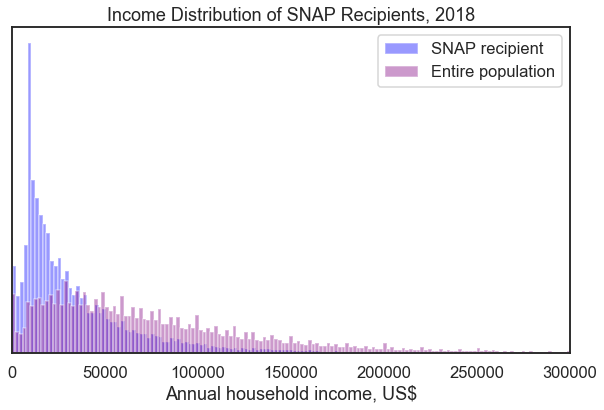

In [4]:
df_ = df.groupby('FS').apply(lambda x: x.sample(frac = 0.25))
df_.index = df_.index.droplevel(0)        
income_distribution_plot(df_)

Next, we split our data into two: training and test, after stratifying by SNAP enrollment. 

In [5]:
from sklearn.model_selection import train_test_split
y = df_.FS
X = (df_.drop(['FS', 'SERIALNO', 'REGION', 'DIVISION', 'ST', 'PUMA'], axis = 1))
X_train, X_test, y_train, y_test = (train_test_split(X, y,
                                                     stratify = y,
                                                     test_size = 0.25,
                                                     random_state = 1007))

We perform scaling and one-hot encoding on the data.

In [6]:
from sklearn.preprocessing import StandardScaler
cont_feats = (['HINCP', 'VEH', 'NP', 'NPF', 'NRC', 'BDSP', 'BLD', 'RMSP',
               'YBL', 'CONP', 'ELEP', 'GASP', 'FULP', 'INSP', 'MHP',
               'RNTP', 'WATP', 'GRNTP', 'SMOCP'])
sclr = StandardScaler()
X_train_cont = (pd.DataFrame(sclr.fit_transform(X_train[cont_feats]),
                             columns = cont_feats))

In [7]:
def encoder_transform(encoder, X):
    X_encoded = encoder.transform(X).toarray()
    encoded_feats = list(encoder.get_feature_names())
    feats = X.columns
    encoded_feats_updated = []
    for feat in encoded_feats:
        feat_split = feat.split('_')
        i = int(feat_split[0][1:])
        dummies = feat_split[1]
        feat_updated = f'{feats[i]}_{dummies}'
        encoded_feats_updated.append(feat_updated)
    return pd.DataFrame(X_encoded, columns = encoded_feats_updated)

In [8]:
from sklearn.preprocessing import OneHotEncoder
cat_feats = X_train.drop(cont_feats, axis = 1).columns
encdr = OneHotEncoder(handle_unknown = 'ignore')
encdr.fit(X_train[cat_feats])
X_train_cat = encoder_transform(encdr, X_train[cat_feats])
X_train = pd.concat((X_train_cont, X_train_cat), axis = 1)
y_train = y_train.astype('int')

We transform the test data using the scaler and encoder fitted to the training data. 

In [9]:
X_test_cont = (pd.DataFrame(sclr.transform(X_test[cont_feats]),
                            columns = cont_feats))
X_test_cat = encoder_transform(encdr, X_test[cat_feats])
X_test = pd.concat((X_test_cont, X_test_cat), axis = 1)
y_test = y_test.astype('int')

### Logistical Regression 

Before we fit a logistical regression model we test the features for multicollinearity. We find that variance inflation factor for at least 15 of our features is infinity. We reach this conclusion by running the following function 15 times. The results are below. We re-try including geographical features. In this case, multicollinearity does not seem to be so much of a problem as it can be addressed by dropping only two features. But, the ROC curve shows that the model performs worse than random guessing. Therefore, we decide that logistical regression may not be a good fit for our data after all.  

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
def multicollinearity_test(X_train):
    c = X_train[X_train.columns[np.arange(X.shape[1])]].values
    print('Created c')
    vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
    print('Calculated vif')
    maxloc = vif.index(max(vif))
    print(f'Max = {X_train.columns[maxloc]} at {max(vif)}')
    if max(vif) > 8:
        return X_train.columns[maxloc]

We run the following loop three times.

In [11]:
feats = X_train
for i in range(15):
    drop = multicollinearity_test(feats)
    if drop != None:
        feats = feats.drop(drop, axis = 1)

Created c


/Users/flatironschol/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/flatironschol/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Calculated vif
Max = WIF_0 at inf
Created c
Calculated vif
Max = WORKSTAT_0 at inf
Created c
Calculated vif
Max = WORKSTAT_10.0 at inf
Created c
Calculated vif
Max = WORKSTAT_13.0 at inf
Created c
Calculated vif
Max = HHL_1.0 at inf
Created c
Calculated vif
Max = FPARC_0 at inf
Created c
Calculated vif
Max = FPARC_1.0 at inf
Created c
Calculated vif
Max = HHT_1.0 at inf
Created c
Calculated vif
Max = HUGCL_1.0 at inf
Created c
Calculated vif
Max = HUPAC_1.0 at inf
Created c
Calculated vif
Max = LNGI_1.0 at inf
Created c
Calculated vif
Max = MULTG_1.0 at inf
Created c
Calculated vif
Max = NPP_1.0 at inf
Created c
Calculated vif
Max = NR_1.0 at inf
Created c
Calculated vif
Max = PARTNER_0.0 at inf


### Random Forest

Initially, random forest does not perform very well. The recall score is only 0.28 for the SNAP participants. Hyperparameter tuning does not improve the score except 0.01-0.02 percentage points. As the poor performance may be driven by the large class imbalance (9:1) against the SNAP participants, we use SMOTE to balance the two classes. After SMOTE, the recall score improves to 0.40.     

In [12]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state = 1007)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1007,
                       verbose=0, warm_start=False)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc 
y_test_hat = rf_clf.predict(X_test)
print(classification_report(y_test, y_test_hat))
print(confusion_matrix(y_test, y_test_hat))

              precision    recall  f1-score   support

           1       0.94      0.97      0.95     70686
           2       0.60      0.40      0.48      7908

    accuracy                           0.91     78594
   macro avg       0.77      0.69      0.72     78594
weighted avg       0.90      0.91      0.90     78594

[[68551  2135]
 [ 4741  3167]]


### Gradient Descent

We use AdaBoost classifier with a weak decision tree as the estimator. The recall score before SMOTE is 0.38. Better than random forest. SMOTEing does not affect the score: it remains at 0.39. 

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4), random_state = 1007)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [19]:
y_test_hat = ada_clf.predict(X_test)
print(classification_report(y_test, y_test_hat))
print(confusion_matrix(y_test, y_test_hat))

              precision    recall  f1-score   support

           1       0.93      0.97      0.95     70686
           2       0.59      0.39      0.47      7908

    accuracy                           0.91     78594
   macro avg       0.76      0.68      0.71     78594
weighted avg       0.90      0.91      0.90     78594

[[68515  2171]
 [ 4788  3120]]


### Linear support vector classifier 

Lastly, we run a support vector classifier. Initially, the model performs very poorly. The recall score is only 0.17. SMOTE affects the performance of this classifier the most. The recall score jumps to 0.81 after SMOTE. 

In [29]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(fit_intercept = False, random_state = 1007)
svm_clf.fit(X_train, y_train)

/Users/flatironschol/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1007, tol=0.0001,
          verbose=0)

In [26]:
y_test_hat = svm_clf.predict(X_test)
print(classification_report(y_test, y_test_hat))
print(confusion_matrix(y_test, y_test_hat))

              precision    recall  f1-score   support

           1       0.97      0.80      0.88     70686
           2       0.31      0.81      0.45      7908

    accuracy                           0.80     78594
   macro avg       0.64      0.80      0.66     78594
weighted avg       0.91      0.80      0.83     78594

[[56464 14222]
 [ 1507  6401]]


Despite increasing the number of iterations to 5000, the linear support vector classifier does not converge. As it still gives us the best recall score, we stick with this model and as the final step tune the hyperparameters.

In [28]:
from sklearn.model_selection import GridSearchCV
param_dist = {'C': [0.1, 10, 100]}
gs = GridSearchCV(svm_clf, param_dist, cv = 3, scoring = 'recall')
gs.fit(X_train, y_train)
gs.best_params_

/Users/flatironschol/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatironschol/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatironschol/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatironschol/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/flatironschol/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear f

{'C': 0.1}

C = 0.1 gives a better score than C = 10, but not from C = 1. We stick with the default parameters.

In [32]:
y_test_hat = gs.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_test_hat)
print(classification_report(y_test, y_test_hat))
print(cm)

              precision    recall  f1-score   support

           1       0.97      0.80      0.88     70686
           2       0.31      0.81      0.45      7908

    accuracy                           0.80     78594
   macro avg       0.64      0.80      0.66     78594
weighted avg       0.91      0.80      0.83     78594

[[56427 14259]
 [ 1507  6401]]


## Results and Conclusion

Overall, our model is a good classifier with an AUC of 0.88 and is able to classify 81% of the SNAP participants and 80% of the rest of the population accurately. While doing that, the model finds 18% of the overall population as similar to the SNAP participants in terms of their income, assets, and spending even though they are not enrolled to the program. This may imply that the program is not reaching enough people and/or right people.  

AUC: 0.8801957987815943


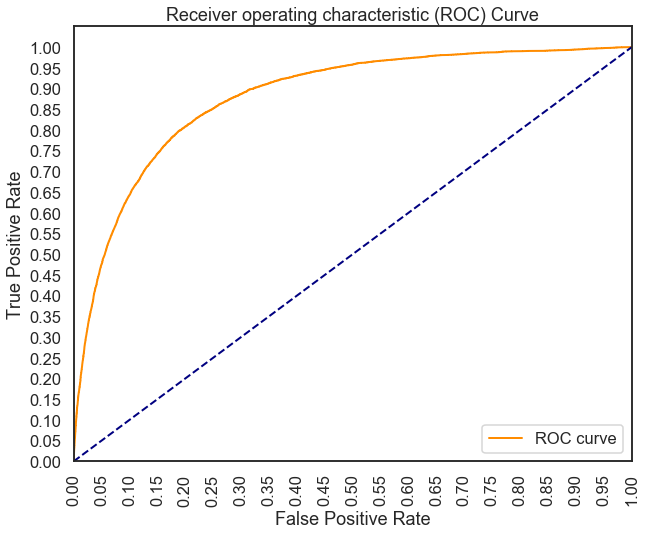

In [39]:
%matplotlib inline
%run visualizations.py
y_score = svm_clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label = 2)
print('AUC: {}'.format(auc(fpr, tpr)))
roc_plot(fpr, tpr)

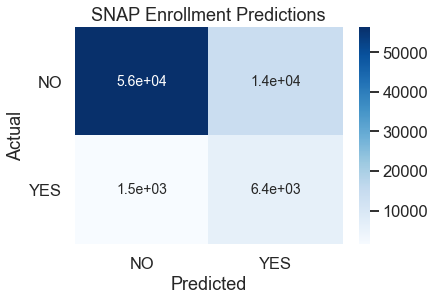

In [34]:
confusion_matrix_plot(cm)

Looking at feature importances, we find that, expectedly, income is negatively correlated with participating to the SNAP while unemployment and household/family size have positive correlations. Surprisingly, number of children has negative correlation with SNAP enrollment. One recommendation might be to examine why people with more children do not enroll to the SNAP program given that they are eligable based on income. The same applies to same-sex couples.  

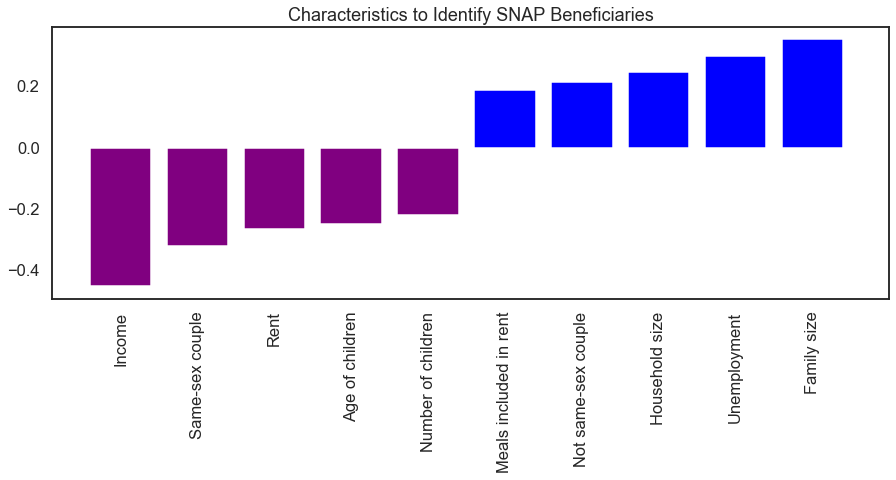

In [40]:
important_features_plot(X_train, svm_clf.coef_.ravel())

## Future Research
The main avenues for future research are two:
- Due to computational complexity, we sampled 25% of the data. However, we also noticed that increasing the number of observations increases the performance of the models. Therefore, the first option would be to try to use the entire data, possibly also including multiple years.
- The second option is about the features included to the model. The large number of features may be leading to overfitting of the model. Therefore, PCA would help us reduce the number of features, and possibly increase the model performance.  